## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/current_data/MET/

/content/drive/My Drive/current_data/MET


In [ ]:
!pip install utide

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 987.0 kB/s eta 0:00:00


In [ ]:
!pip install skyfield

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.9/453.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 17.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utide

import scipy.io
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
from utide import solve
from utide import reconstruct
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from skyfield.api import N,S,E,W, wgs84
from skyfield.api import load
from tqdm import tqdm, tqdm_notebook
import math

import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D
from keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Add


/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


### Constants:

In [ ]:
### Synthetic data based off of the tides at Easport, ME, USA

constits = ['M2', 'N2', 'S2', 'L2', 'K1', 'NU2', 'O1', 'K2', '2N2', 'M4',
       'LDA2', 'P1', 'M6', '2MN6', 'SSA', 'MM', 'MN4', '2MS6', 'Q1',
       'MS4', 'OQ2', 'MF', 'EPS2', 'NO1', 'MU2', 'MSF', 'MSN2', 'MKS2',
       'MSM', 'TAU1', 'CHI1', '2MK6', 'SIG1', 'M8', '2Q1', 'ALP1', 'J1',
       'MK3', 'OO1', 'RHO1', 'MO3', 'THE1', 'ETA2', 'MK4', 'M3', 'PHI1',
       'SO1', 'MSK6', '2SM6', '2MK5', '2SK5', 'SO3', 'SK4', 'S4', 'SN4',
       'UPS1', 'SK3', '3MK7', 'BET1']

constit_freqs = [8.05114007e-02, 7.89992487e-02, 8.33333333e-02, 8.20235526e-02,
       4.17807462e-02, 7.92016200e-02, 3.87306545e-02, 8.35614924e-02,
       7.74870967e-02, 1.61022801e-01, 8.18211814e-02, 4.15525871e-02,
       2.41534202e-01, 2.40022050e-01, 2.28159110e-04, 1.51215197e-03,
       1.59510649e-01, 2.44356135e-01, 3.72185025e-02, 1.63844734e-01,
       7.59749448e-02, 3.05009177e-03, 7.61773160e-02, 4.02685942e-02,
       7.76894680e-02, 2.82193266e-03, 8.48454853e-02, 8.07395598e-02,
       1.30978069e-03, 3.89588136e-02, 4.04709655e-02, 2.44584294e-01,
       3.59087218e-02, 3.22045603e-01, 3.57063505e-02, 3.43965698e-02,
       4.32928982e-02, 1.22292147e-01, 4.48308380e-02, 3.74208738e-02,
       1.19242055e-01, 4.30905269e-02, 8.50736444e-02, 1.64072893e-01,
       1.20767101e-01, 4.20089053e-02, 4.46026789e-02, 2.47406226e-01,
       2.47178067e-01, 2.02803548e-01, 2.08447413e-01, 1.22063988e-01,
       1.66894826e-01, 1.66666667e-01, 1.62332582e-01, 4.63429900e-02,
       1.25114080e-01, 2.83314948e-01, 4.00404351e-02]

amplitudes = [2.69536915e+00, 5.72051193e-01, 4.07506583e-01, 1.77388101e-01,
       1.47556429e-01, 1.19429297e-01, 1.09452258e-01, 1.04476023e-01,
       8.61191165e-02, 6.23530012e-02, 5.25568128e-02, 5.24018291e-02,
       5.19452145e-02, 3.00794037e-02, 2.84902243e-02, 2.43228739e-02,
       2.36208636e-02, 2.23206826e-02, 2.16932828e-02, 1.69515192e-02,
       1.59876603e-02, 1.55192273e-02, 1.39270008e-02, 1.31075437e-02,
       1.16664290e-02, 1.12614002e-02, 1.00992138e-02, 9.90031008e-03,
       9.78086103e-03, 6.67196947e-03, 6.30213718e-03, 6.03839327e-03,
       5.79057561e-03, 5.58555813e-03, 5.53185602e-03, 5.09334554e-03,
       4.94360009e-03, 4.20564738e-03, 3.95227210e-03, 3.94934833e-03,
       3.89841590e-03, 3.89051376e-03, 3.83732293e-03, 3.53288437e-03,
       2.81478065e-03, 2.33707655e-03, 2.24773556e-03, 2.01115802e-03,
       1.60006625e-03, 1.42035014e-03, 1.25888117e-03, 1.21582618e-03,
       1.15983346e-03, 1.13589867e-03, 7.27191018e-04, 5.66714794e-04,
       4.59664834e-04, 4.42728050e-04, 3.61904833e-04]

phases = [100.17759146,  67.89243773, 139.00250991, 137.86574464,
       200.97272826,  74.79464737, 165.69341288, 153.88678437,
        58.36570311,  89.0912145 , 127.98741436, 191.68500006,
       278.47737423, 244.0325824 , 177.04405382,  44.34332198,
        52.25904325, 323.89847841, 133.57991772, 136.30167208,
        28.30723094, 217.33413263, 126.53992866, 161.0469261 ,
       174.82541658,  15.58408105,   7.47832655,  31.42622825,
        97.44531604,  99.02486302,  68.17868939, 330.05943051,
       150.29924914, 251.95764691, 210.86869631,   7.60600294,
       230.66692903,  69.11247392, 271.44019503,  86.11567323,
       339.08199382, 158.8889673 ,  35.15053441, 133.53233952,
       257.70571862,   5.82066898, 106.55105815,  20.09288806,
         6.71678559, 332.8022366 ,  84.89100071,  26.87074928,
       195.77759826, 285.62386608, 303.69083469, 319.58250059,
        45.59421571,   9.39030707, 156.23344292]

### Helper Functions:

In [ ]:
def calc_stats(test_predictions, test_labels, verbose = True):
  r2 = r2_score(test_predictions, test_labels)
  mse = mean_squared_error(test_predictions, test_labels)
  mae = mean_absolute_error(test_predictions, test_labels)
  mape = mean_absolute_percentage_error(test_predictions, test_labels)

  if verbose:
    print(f"r2: {r2} MSE: {mse} MAE : {mae} MAPE : {mape}")
  return r2, mse,mae,mape


import random

def random_indices_within_chunks(lst, x, l):
    """
    Randomly select indices within chunks of a list, excluding l indices from both ends.

    Parameters:
    - lst: The input list.
    - x: The length of each chunk.
    - l: The number of excluded indices from both ends of each chunk.

    Returns:
    - A list of randomly selected indices.
    """
    indices = []
    chunk_start = 0
    seed_val = 0
    while chunk_start < len(lst):
        chunk_end = min(chunk_start + x, len(lst))
        valid_indices = list(range(chunk_start + l, chunk_end - l))

        if valid_indices:
            random.seed(seed_val)
            random_index = random.choice(valid_indices)
            indices.append(random_index)
            seed_val+=1
        chunk_start = chunk_end

    return indices

def create_response_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()

    model.add(Dense(dim, input_dim=dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    #model.add(Dense(dim, activation='relu'))
    #model.add(Dense(int(math.factorial(dim) / (math.factorial(2)*math.factorial(dim -2))), activation='linear'))
    #model.add(Dense(dim, activation='relu', name = 'nonlinear_layer2'))
    # check to see if the regression node should be added
    if regress:
      model.add(Dense(1))
    else:
      pass
    #model.add(Dense(1))
    return model


def multi_model(input_dims, nontidal, regularization_strength = 0.0):
  '''Builds Multi-Input Model:'''
  mlp_u = create_response_mlp(input_dims-1-nontidal, regress=False)
  surge = keras.Input(shape=(1,), name = 'surge')
  surges = keras.Input(shape=(nontidal,), name = 'surges')

  mlp_regress = Dense(1)(mlp_u.output)
  lins = Add()([mlp_regress, surge])
  combinedInput = concatenate([mlp_u.output, surge, surges])
  x = Dense(70, activation="relu", name = 'base1', kernel_regularizer=regularizers.l1_l2(l1=0.0, l2=regularization_strength))(combinedInput)
  x2 = Dense(70, activation="relu", name = 'base2', kernel_regularizer=regularizers.l1_l2(l1=0.0, l2=regularization_strength))(x)
  y = Dense(1)(x2)

  z = Add()([lins, y])


  #z = [lins, y]

  #x = Dense(2)(x)
  model = Model(inputs=[mlp_u.input, surge, surges], outputs=[z])
  return model

def train_test_data(df,length_val, lati, mult_val, nontidal, shift_val=0):
  ### Setting up Global Training

  dataset_U = df.values
  #dataset_U = df.values
  num_features = np.shape(dataset_U)[1]

  short_utide = utide.solve(
    df[:length_val].index,
    df[:length_val].observations,
    lat=lati,
    method="robust",
    conf_int="MC",
    verbose=False,
    trend = False
    )

  short_pred = reconstruct(df[:].index, short_utide, verbose = False)
  utide_preds_u= short_pred['h']


  ### Setting up Linear Training
  train_X_U_LIN = dataset_U[:len(utide_preds_u), 2:num_features-nontidal]
  train_Y_U_LIN = utide_preds_u

  train_X_V_LIN = np.zeros(len(utide_preds_u))
  train_X_surge_LIN = np.zeros(np.shape(dataset_U[:len(utide_preds_u), num_features-nontidal:num_features]))
  ### Setting up Global Training

  train_X_U = dataset_U[:length_val, 2:num_features-nontidal]
  train_X_V = dataset_U[:length_val, 1:2]

  train_X_surge = dataset_U[:length_val, num_features-nontidal:num_features]

  train_Y_U = dataset_U[:length_val, 0:1]

  test_X_U = dataset_U[:length_val, 2:num_features-nontidal]

  test_X_V = np.zeros(np.shape(dataset_U[:length_val, 1:2]))
  test_X_surge = np.zeros(np.shape(dataset_U[:length_val, num_features-nontidal:num_features]))

  test_Y_U = dataset_U[:length_val, 0:1]

  #return scaled_train_X, scaled_train_Y, scaled_test_X, test_Y, scaler_X, scaler_Y, num_features
  return train_X_U_LIN, train_X_V_LIN, train_Y_U_LIN,train_X_surge_LIN, train_X_U, train_X_V, train_Y_U, train_X_surge, test_X_U, test_X_V, test_Y_U, test_X_surge, num_features



### RTide

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def cosd(x):
  return np.cos(np.deg2rad(x))
def sind(x):
  return np.sin(np.deg2rad(x))

def mfft(x,DeltaTau):
  return np.exp(1j*-2*np.pi*x*DeltaTau)

def pad_dataframe(df, N):
    # Determine the frequency of the existing index values
    freq = pd.infer_freq(df.index)

    if freq is None:
        freq_counts = df.index.to_series().diff().value_counts()
        most_common_freq = freq_counts.idxmax()
        freq = most_common_freq

    # Create a new DataFrame with the desired frequency and UTC timezone
    new_index = pd.date_range(start=df.index[0] - pd.DateOffset(hours=N), end=df.index[-1] + pd.DateOffset(hours=N), freq=freq, tz='UTC')
    padded_df = pd.DataFrame(index=new_index)
    # Merge the existing DataFrame with the padded DataFrame based on the index
    padded_df = padded_df.merge(df, how='left', left_index=True, right_index=True)


    # Fill missing values in the padded DataFrame with zeros
    #padded_df.fillna(0, inplace=True)

    return padded_df

def dim_reduc(values, plot = False):
  X = np.array(values).T
  scaler = StandardScaler()
  X_standardized = scaler.fit_transform(X)

  # Step 3: Calculate the Covariance Matrix
  covariance_matrix = np.cov(X_standardized, rowvar=False)

  # Step 4: Eigenvalue Decomposition
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

  pca = PCA().fit(X_standardized)
  explained_variance = pca.explained_variance_ratio_
  cumulative_explained_variance = np.cumsum(explained_variance)
  if plot:
    plt.title(f'Total Variance Explained by {k} components: {cumsum}')
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
  ind = 0
  cumsum = cumulative_explained_variance[0]
  while cumsum < .985:
    ind +=1
    cumsum = cumulative_explained_variance[ind]

  k = ind+1  # You can adjust this as needed
  top_eigenvalues_indices = np.argsort(eigenvalues)[::-1][:k]
  selected_eigenvectors = eigenvectors[:, top_eigenvalues_indices]

  # Step 6: Projection
  return np.dot(X_standardized, selected_eigenvectors).T


class RTide:
  def __init__(self, ts, lat, lon, mult_val, negative_real = None, datatype='heights', path = None):
      self.ts = ts
      self.N = len(ts)
      self.height = self.ts.values
      self.lat = lat
      self.lon = lon
      self.mult_val = mult_val
      #self.time_step = self.ts.index.freq.delta.seconds /86400 ##  Cycles per day
      self.total_days = (self.ts.index.max() - self.ts.index.min()).total_seconds() / 86400
      self.path = path
      self.negative_real = negative_real
      #self.n = 2*self.total_days/self.time_step
      self.M_E = 5.9722*10**24 ## Mass Earth
      self.M_M = 7.3 *10**22 ## Mass Moon
      self.M_S = 1.989 * 10**30 ## Mass Sun
      self.E_r = 6371.01*10**3 ## Earth Radius (denoted a in Response Paper)
      self.solar_constant = 1.946/100  ## Note in CM (Trying to convert to meters)
      self.degrees = range(1,3) ## Number of spherical harmonic degrees to compute.
      self.datatype = datatype
      self.multi = True if np.shape(ts)[1] > 1 else False

  def Spherical_Harmonic(self,degree, order):
    '''PreDefined Legendre Polynomials for speed:

       Stored in a nested list defined by:
       P_vals where i is the degree of the associated Legendre polynomials.
       Each value in the list is the Legendre polynomial of degree i and order
       equal to its index value in the list.

       Theta = geographical colatitude of station
       Lambda = longitude of station

       For Example:
       P_2 = [P_2^0,P_2^1, P_2^2] '''
    P_0 = [1]
    P_1 = [cosd(self.lat), sind(self.lat)]
    P_2 = [(1.5)*cosd(self.lat)**2 - .5, 3*sind(self.lat)*cosd(self.lat), 3*sind(self.lat)**2]
    P_3 = [(2.5)*cosd(self.lat)**3 - 1.5*cosd(self.lat), 1.5*sind(self.lat) * (5*cosd(self.lat)**2 -1), 15*sind(self.lat)**2 * cosd(self.lat), 15* sind(self.lat)**3]
    P_vals = [P_0,P_1,P_2,P_3]
    try:
      Y = (-1)**(order) *(2*degree + 1 / (4*np.pi))**(1/2) * (math.factorial(degree-order)/math.factorial(degree+order)) *cosd(self.lat) * np.exp(1j*order*self.lon)*P_vals[degree][order]
      return Y
    except ValueError:
      print("Order must be less than or equal to the degree")


  def Radiational(self, degree, order,filtered = False):
    '''Computes the Global Radiation Function for all zenith angles'''
    degree= int(degree)
    if degree > 2:
      raise ValueError('Currently only equipped to handle k = 0,1,2.')
    parallax = 1.0/23455.0
    k_n = [1/4 + (1/6)*parallax, (1/2) + (3/8)*parallax, (5/16) + (1/3)*parallax]

    SPH = self.Spherical_Harmonic(degree, order)
    k = k_n[degree]
    rads = pd.DataFrame(self.astro['zenith_sun'])
    rads['rad'] = self.solar_constant * (self.mean_r_sun / self.astro['station2sun']) * k * self.astro['mu_sun']**degree
    rads.loc[(rads['zenith_sun'] >=90) & (rads['zenith_sun'] <= 180), 'rad'] = 0
    return rads['rad'].to_numpy() / SPH

  def Gravitational(self, degree, order, filtered=False):
    """Computes the Gravitational Input function for each t of the observed time series:

       Assumes that the combined gravitational input function is equal to the sum of the
       lunar and solar input functions.

       **Currently using predefined Legendre functions as defined in Munk & Carwright
       Inputs
       --------
       degree: int (0,3)

       Returns
       --------
       : DataFrame

       Sum of gravitational forces from the moon and sun at specified degree. """
    degree= int(degree)
    if degree > 3:
       raise ValueError('Currently only equipped to handle k = 0,1,2,3.')

    SPH = self.Spherical_Harmonic(degree, order)
    ## Computing associated k values
    K_n_Moon = self.E_r * (self.M_M / self.M_E) * (self.E_r/ self.astro['earth2moon'])**(degree+1)
    K_n_Sun = self.E_r * (self.M_S / self.M_E) * (self.E_r/ self.astro['earth2sun'])**(degree+1)

    grav_Moon= K_n_Moon * (self.mean_r_moon/ self.astro['earth2moon'])**(degree+1) * self.Lunar_Legendre[degree]
    grav_Sun= K_n_Sun * (self.mean_r_sun/ self.astro['earth2sun'])**(degree+1)  * self.Solar_Legendre[degree]

    if self.datatype == 'currents':
      grav_Moon_U  = grav_Moon *cosd(self.astro['azimuth_moon'])
      grav_Moon_V  = grav_Moon *sind(self.astro['azimuth_moon'])
      grav_Sun_U  = grav_Sun *cosd(self.astro['azimuth_sun'])
      grav_Sun_V  = grav_Sun *sind(self.astro['azimuth_sun'])
      return (grav_Moon_U + grav_Sun_U).to_numpy() / SPH, (grav_Moon_V + grav_Sun_V).to_numpy() / SPH

    filtered_series =  (grav_Moon + grav_Sun).to_numpy()

    return filtered_series / SPH

  def Global_Tide(self):
    ''' Computes global tide function according to specified input functions
        Note** Radiational function commences with P_1(mu) and gravitational
        commences at P_2(mu)

        ** Note currently only setup to handle radiation and gravitational
        input functions (dictionary initialization will need to be adjusted)

        Going to have the primary output still be the dictionary, however,
        the respective functions will also be added to self.helper_df. One of these
        functionalities can be removed for increased speed.

        Returns
        --------
        : DataFrame
        Format: {'Radiational':{degree: Associated Radiational Input Values,...}
                 'Gravitational':{degree: Associated Gravitational Input Values,...}}

        Values are numpy arrays containing the instantaneous values of the input function for each time.

        returned as: self.global_tide'''
    self.Astro()
    ## Creating Helper_df ## Originally was checking the datatype to see if it was 'sim'. Assuming this has been resolved.
    self.helper_df = self.padded_ts
    if self.datatype != 'currents':
      self.global_tide = {'Radiational':{i: {k: 0 for k in range(1,i+1)} for i in range(1,3)}, 'Gravitational':{i:{k: 0 for k in range(1,i+1)} for i in range(2,4)}}
      for i in tqdm(self.global_tide, leave=False, desc='Computing Global Tide Function'):
        for j in self.global_tide[i]:
          if i == 'Radiational':
            for k in range(j+1):
              self.global_tide[i][j][k] = self.Radiational(degree = j, order = k, filtered = filter) ## Computes the Radiational Function at each Solar Zenith Angle For degree j.
              self.helper_df[f'{i}_{j}^{k}'] = self.global_tide[i][j][k]
          elif i == 'Gravitational':
            for k in range(j+1):
              self.global_tide[i][j][k] = self.Gravitational(degree = j, order = k, filtered = filter) ## Computes the Gravitational Function at each Solar/Lunar Zenith Angle  for degree j
              self.helper_df[f'{i}_{j}^{k}'] = self.global_tide[i][j][k]
          else:
            print("eTide is currently only equipped to handle gravitational and radiational inputs")
    else:
      self.global_tide = {'Radiational':{i: {k: 0 for k in range(1,i+1)} for i in range(1,3)}, 'Gravitational':{i:{k: {'u':0, 'v':0} for k in range(1,i+1)} for i in range(2,4)}}
      for i in tqdm(self.global_tide, leave=False, desc='Computing Global Tide Function'):
        for j in self.global_tide[i]:
          if i == 'Radiational':
            for k in range(j+1):
              self.global_tide[i][j][k] = self.Radiational(degree = j, order = k, filtered = filter) ## Computes the Radiational Function at each Solar Zenith Angle For degree j.
              self.helper_df[f'{i}_{j}^{k}'] = self.global_tide[i][j][k]
          elif i == 'Gravitational':
            for k in range(1,j+1):
              self.global_tide[i][j][k]['u'], self.global_tide[i][j][k]['v'] = self.Gravitational(degree = j, order = k, filtered = filter) ## Computes the Gravitational Function at each Solar/Lunar Zenith Angle  for degree j
              self.helper_df[f'{i}_{j}^{k}_u'] = self.global_tide[i][j][k]['u']
              self.helper_df[f'{i}_{j}^{k}_v'] = self.global_tide[i][j][k]['v']
          else:
            print("RTide is currently only equipped to handle gravitational and radiational inputs")


  def Astro(self):
    """Computs the associated astronomical positions and angles of the Moon and Sun
     relative to the station and center of the Earth."""
    ## Converting time index to appropriate format
    tindex = self.padded_ts.index.to_pydatetime()
    tscale = load.timescale()
    times = tscale.utc(tindex)
    ## Loading planet objects from skyfield
    planets = load('de421.bsp')
    earth, moon, sun = planets['earth'], planets['moon'], planets['sun']

    ## Computing Distances:
    earth_moon = [(moon.at(t) - earth.at(t)).distance().m for t in tqdm(times, leave=False, desc='Computing Distances From Earth to Moon')]## Returns Moons distance in meters
    earth_sun = [(sun.at(t) - earth.at(t)).distance().m for t in tqdm(times, leave=False, desc='Computing Distances From Earth to Sun')] ## Returns Suns distance in meters

    ## Computing Angles:
    moon_stat_dist = []
    sun_stat_dist = []
    zenith_moon = []
    zenith_sun = []
    azimuth_moon = []
    azimuth_sun = []
    for t in tqdm(times, leave=False, desc='Computing Distances/Angles From Station to Moon/Sun'):
      station_location = earth + wgs84.latlon(self.lat, self.lon)
      astro_moon = station_location.at(t).observe(moon)
      astro_sun = station_location.at(t).observe(sun)

      app_moon = astro_moon.apparent()
      app_sun = astro_sun.apparent()


      alt_moon, az_moon, stat_dist_moon = app_moon.altaz()
      alt_sun, az_sun, stat_dist_sun = app_sun.altaz()


      ## Zenith angle is equal to +90 for alt.
      zenith_moon.append(90 - alt_moon.degrees)
      zenith_sun.append(90 - alt_sun.degrees)

      azimuth_moon.append(az_moon.degrees)
      azimuth_sun.append(az_sun.degrees)

      moon_stat_dist.append(stat_dist_moon.m)
      sun_stat_dist.append(stat_dist_sun.m)
    self.mu_moon = cosd(zenith_moon) ## Mu Moon
    self.mu_sun = cosd(zenith_sun) ## Mu Sun
    self.alpha = zenith_sun ## Solar Zenith Angle
    self.mean_r_sun = np.sum(earth_sun) / len(earth_sun) ## Average Distance to sun
    self.mean_r_moon = np.sum(earth_moon) / len(earth_moon)
    self.station2sun = sun_stat_dist ## Distance from Station to Sun

    ## Associated Legendre Functions
    self.Solar_Legendre =  [1,self.mu_sun, [(3/2)*mew**2 - (1/2) for mew in self.mu_sun], [(5/2)*mew**3 - (3/2)*mew for mew in self.mu_sun]]
    self.Lunar_Legendre = [1,self.mu_moon, [(3/2)*mew**2 - (1/2) for mew in self.mu_moon], [(5/2)*mew**3 - (3/2)*mew for mew in self.mu_moon]]
    self.astro = pd.DataFrame({'station2moon':moon_stat_dist, 'station2sun': sun_stat_dist, 'earth2moon': earth_moon, 'earth2sun': earth_sun, 'zenith_moon': zenith_moon, 'zenith_sun': zenith_sun, 'mu_sun': cosd(zenith_sun), 'azimuth_moon': azimuth_moon, 'azimuth_sun': azimuth_sun}, index = self.padded_ts.index)

  def Prep(self, lag_days, pos):
    ## First Run basic utide to figure out how many constits it can handle
    if self.datatype != 'currents':
      short_utide = utide.solve(
      self.ts[:lag_days*24*self.mult_val].index,
      self.ts[:lag_days*24*self.mult_val].observations,
      lat=self.lat,
      method="ols",
      conf_int="MC",
      verbose=False,
      trend = False
      )
    else:
      short_utide = utide.solve(
      self.ts[:lag_days*24*self.mult_val].index,
      self.ts[:lag_days*24*self.mult_val].u,
      self.ts[:lag_days*24*self.mult_val].v,
      lat=self.lat,
      method="ols",
      conf_int="MC",
      verbose=False,
      trend = False
      )
    ## Sorting Lags and Determining Largest Constit
    ## I think it should already have the correct units.
    nonuni = []
    for i,j in enumerate(np.sort(short_utide['aux']['frq'])):
      if (len(nonuni) != 0) and (nonuni[-1] == -self.mult_val*int(2*np.pi / j)):
        pass
      else:
        nonuni.append(-self.mult_val*int(2*np.pi / (j)))
    nonuni.append(0)
    for i in np.flip(np.sort(short_utide['aux']['frq'])):
      if nonuni[-1] == self.mult_val*int(2*np.pi / (i)):
        pass
      else:
        nonuni.append(self.mult_val*int(2*np.pi / (i)))
    def neg(lst):
        return [x for x in lst if x <= 0]
    if not pos:
      self.nonunilags= neg(nonuni)
    else:
      self.nonunilags = nonuni

    if not self.negative_real:
      self.max_lag = max(nonuni)*self.mult_val ## Just checking
    else:
      self.max_lag = max(self.negative_real, max(nonuni))*self.mult_val
    ## Getting Associated Constituent Names:
    sorts = np.argsort(short_utide['aux']['frq'])
    constits = list(short_utide['name'])
    new_vals = [constits[i] for i in sorts]
    new_vals2 = [constits[i] for i in np.flip(sorts)]
    new_vals.append('real')
    self.const_names = new_vals+ new_vals2
    ## Pad out to that point
    self.padded_ts = pad_dataframe(self.ts, int(self.max_lag / self.mult_val))

  def Prepare_Dfs(self, reduce = False, customlags = False, lag_days = 8, radiational = True, pos = False):
    ## Let's check if this exists already:
    if self.path:
      try:
        self.Prep(lag_days, pos)
        prepped_dfs = pd.read_csv(f'{self.path}global_tide.csv',index_col=0)
        prepped_dfs.index = self.ts.index
        self.prepped_dfs = prepped_dfs
      except:
        self.Prep(lag_days, pos)
        self.Global_Tide()
        grav_names = []
        grav_values = []
        rad_values = []
        rad_names = []
        for i in self.global_tide['Radiational']:
          for j in self.global_tide['Radiational'][i]:
            rad_values.append(self.global_tide['Radiational'][i][j].real)
            rad_names.append('Radiational_' + str(i) +'^' +str(j))
        for i in self.global_tide['Gravitational']:
          for j in self.global_tide['Gravitational'][i]:
            grav_names.append('Gravitational_' + str(i)+'^' + str(j))
            grav_values.append(self.global_tide['Gravitational'][i][j].real)
        ## Initializing list of dfs that will be concatenated
        dfs = [self.ts]
        ## If not using PCA to reduce number of inputs
        if not reduce:
          ## Computing lags for gravitational inputs
          for i,name in enumerate(grav_names):
              gravs_real = [pd.DataFrame({name +'_'+ str(lag)+'_'+self.const_names[z]: np.array(grav_values[i][self.max_lag +lag: lag -self.max_lag-1])}, index = self.ts.index[:-1]) for z,lag in enumerate(self.nonunilags)]
              for x in range(len(gravs_real)):
                dfs.append(gravs_real[x])
          ## Computing lags for radiational inputs
          if radiational:
            for i,name in enumerate(rad_names):
                rads_real = [pd.DataFrame({name+'_'+ str(lag)+'_'+self.const_names[z]: np.array(rad_values[i][self.max_lag + lag :lag -self.max_lag-1])}, index = self.ts.index[:-1]) for z,lag in enumerate(self.nonunilags)]
                for x in range(len(rads_real)):
                  dfs.append(rads_real[x])
        else:
          ## Using PCA to reduce inputs
          ## Computing PCA for both Gravitational and Radiational Inputs
          gravs_red = dim_reduc(grav_values)
          rads_red = dim_reduc(rad_values)
          ## Computing lags for reduced gravtiational
          for i in range(len(gravs_red)):
              gravs_red_real = [pd.DataFrame({f'gravitational_reduced_{i}'+ str(lag)+'_'+self.const_names[z]: gravs_red[j][self.max_lag +lag: lag -self.max_lag-1]}, index = self.ts.index[:-1]) for z,lag in enumerate(self.nonunilags)]
              ## Adding to big dfs
              for x in range(len(gravs_red_real)):
                dfs.append(gravs_red_real[x])
          ## Computing lags for reduced radiational
          for i in range(len(rads_red)):
              rads_red_real = [pd.DataFrame({f'radiational_reduced_{i}'+ str(lag)+'_'+self.const_names[z]: rads_red[i][self.max_lag +lag: lag -self.max_lag-1]}, index = self.ts.index[:-1]) for z,lag in enumerate(self.nonunilags)]
              ## Adding to big dfs
              for x in range(len(rads_red_real)):
                dfs.append(rads_red_real[x])

        ## Added functionality for multivariate and localized forecasting.
        for i,col in enumerate(self.ts.columns):
          if col == 'observations':
            ## Functionality to include actual observations in training set lagged by "negative_real" hours.
            ## For example if I am interested in making 24 hour ahead forecasts I can include the observation from 24 hours
            ## before to improve localization
            if self.negative_real != None:
              negs = -self.negative_real*self.mult_val
              cust_real = pd.DataFrame({'real_lagged'+'_'+ str(negs): self.padded_ts[col][self.max_lag + negs :negs -self.max_lag-1].to_numpy()}, index = self.ts.index[:-1])
              dfs.append(cust_real)
            else:
              pass
          else:
            ## Used for including lagged inputs for custom input functions
            if not customlags:
              ### Need to prevent using realtime data twice:
              index_of_zero = self.nonunilags.index(0)
              multi_lags_list = self.nonunilags.copy()
              # Remove the zero from the list
              multi_lags_list.pop(index_of_zero)

              custom_input = [pd.DataFrame({col+'_'+ str(lag)+'_'+self.const_names[z]: self.padded_ts[col][self.max_lag + lag :lag -self.max_lag-1].to_numpy()}, index = self.ts.index[:-1]) for z,lag in enumerate(multi_lags_list)]
            else:
              if customlags == 'positive':
                def pos(lst):
                  return [x for x in lst if x > 0]
                customlags = pos(self.nonunilags)
              if customlags == 'negative':
                def neg(lst):
                  return [x for x in lst if x < 0]
                customlags = neg(self.nonunilags)
              else:
                print("Custom Lags Are:", customlags)
              custom_input = [pd.DataFrame({col+'_'+ str(lag): self.padded_ts[col][self.max_lag + lag :lag -self.max_lag-1].to_numpy()}, index = self.ts.index[:-1]) for z,lag in enumerate(customlags)]
            for x in range(len(custom_input)):
              dfs.append(custom_input[x])
        prepped_dfs = pd.concat(dfs, join='outer', axis=1)
        self.prepped_dfs = prepped_dfs
        if self.path:
          self.prepped_dfs.to_csv(f'{self.path}global_tide.csv')


  def run_NN(self, train_days = 0, lr = 0.00001, loss= 'MAE', train_epochs = 0, train_epochs2 = 500, verbose = True, regularization_strength = 0.0):
    if verbose:
      print('#### Model Overview ####')
      print('Train days is:', train_days )
      print('Learning Rate is:', lr)
      print('Loss is:', loss)
      print('Linear Epochs:', train_epochs)
      print('Standard Epochs:', train_epochs2)
      print('Regularization:', regularization_strength)
    def compute_ssp(signal1, signal2):
      ### Surface similarity loss function:
      ### https://doi.org/10.1016/j.neunet.2022.09.023
      # Compute the FFT of the signals
      fft_signal1 = tf.signal.rfft(signal1)
      fft_signal2 = tf.signal.rfft(signal2)

      # Calculate the difference in the frequency domain
      numerator = tf.square(tf.abs(fft_signal1 - fft_signal2))
      denom1 = tf.square(tf.abs(fft_signal1))
      denom2 = tf.square(tf.abs(fft_signal2))

      # Sum the absolute values of the differences across all frequencies
      numerator_sum = tf.reduce_sum(numerator)
      denom_sum1 = tf.reduce_sum(denom1)
      denom_sum2 = tf.reduce_sum(denom2)

      ssp = 0.5 * numerator_sum / (denom_sum1 + denom_sum2)

      return ssp

    if train_days == 0:
      ### if no train_days is specified use all available data.
      length_val = len(self.prepped_dfs.dropna())
    else:
      length_val = train_days *24*self.mult_val

    df = self.prepped_dfs.dropna()

    dataset = df.values
    num_features = np.shape(dataset)[1]

    short_utide = utide.solve(
      df[:length_val].index,
      df[:length_val].observations,
      lat=self.lat,
      method="robust",
      conf_int="MC",
      verbose=False,
      trend = False
      )

    short_pred = reconstruct(df[:].index, short_utide, verbose = False)
    utide_preds= short_pred['h']

    ### Setting up Linear Training
    if self.multi == False:
      train_X_LIN = dataset[:len(utide_preds), 1:num_features]

      train_Y_LIN = utide_preds
    else:
      train_X_LIN_standard = dataset[:len(utide_preds), np.shape(self.ts)[1]:num_features-(np.shape(self.ts)[1]-1)*(len(self.nonunilags) + 1)] ### All non self.ts values
      train_X_LIN_multi_start = np.zeros(np.shape(dataset[:len(utide_preds), 1:np.shape(self.ts)[1]])) ### All non self.ts values
      train_X_LIN_multi_end = np.zeros(np.shape(dataset[:len(utide_preds), num_features- (np.shape(self.ts)[1]-1)*(len(self.nonunilags) + 1) : num_features])) ### All non self.ts values

      train_X_LIN = np.concatenate((train_X_LIN_multi_start, train_X_LIN_standard, train_X_LIN_multi_end), axis=1)
      train_Y_LIN = utide_preds

    ### Setting up Global Training

    train_X = dataset[:length_val, 1:num_features]

    train_Y = dataset[:length_val, 0:1]

    if train_days != 0:
      test_X = dataset[length_val:, 1:num_features]
      test_Y = dataset[length_val:, 0:1]
    else:
      test_X = dataset[:length_val, 1:num_features]
      test_Y = dataset[:length_val, 0:1]

    scaler_X_LIN = StandardScaler()
    scaled_train_X_LIN = scaler_X_LIN.fit_transform(train_X_LIN.reshape(-1, 1)).reshape(train_X_LIN.shape)

    scaler_Y_LIN = StandardScaler()
    scaled_train_Y_LIN = scaler_Y_LIN.fit_transform(train_Y_LIN.reshape(-1, 1))


    scaler_X = StandardScaler()
    scaled_train_X = scaler_X.fit_transform(train_X.reshape(-1,1)).reshape(train_X.shape)
    scaled_test_X = scaler_X.transform(test_X.reshape(-1,1)).reshape(test_X.shape)
    scaler_Y = StandardScaler()
    scaled_train_Y = scaler_Y.fit_transform(train_Y.reshape(-1, 1))


    input_dims = num_features-1

    custom_early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=250,
      min_delta=0.0001,
      mode='min'
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=50, min_lr=0.00000001)

    ## Setup Model
    """
    model = Sequential()
    #model.add(Dense(input_dims, input_dim=input_dims, activation=None, name = 'linear_layer'))
    model.add(Dense(input_dims, input_dim=input_dims, activation='relu', name = 'nonlinear_layer1'))
    model.add(Dense(input_dims, activation='relu', name = 'nonlinear_layer2'))
    model.add(Dense(input_dims, activation='relu', name = 'nonlinear_layer3'))
    model.add(Dense(1))
    """

    # Set the regularization strength (you can adjust this value)

    # Set the regularization strengths (you can adjust these values)
    l1_strength = 0.0
    l2_strength = regularization_strength

    # Create the model
    model = Sequential()
    model.add(Dense(input_dims, input_dim=input_dims, activation='relu', name='nonlinear_layer1'))
    model.add(Dense(input_dims, activation='relu', name='nonlinear_layer2', kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dense(input_dims, activation='relu', name='nonlinear_layer3', kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dense(1))


# Compile th

    # Compile Model
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=compute_ssp, optimizer= optimizer)
    #model.compile(loss=mean_absolute_error, optimizer= optimizer)

    history = model.fit(scaled_train_X_LIN, scaled_train_Y_LIN, epochs=train_epochs, batch_size=32, verbose = 2, shuffle = True, validation_split = .3, callbacks=[custom_early_stopping,reduce_lr])

    if train_epochs > 0:
      plt.plot(history.history['loss'], label = 'Loss U')
      plt.plot(history.history['val_loss'], label = 'Val Loss U')
      plt.legend()
      plt.show()

    # Now lets retrain the nonlinear layer:
    #model_U.get_layer('linear_layer').trainable = False
    #model.get_layer('linear_layer').trainable = True
    if loss == 'MAE':
      model.compile(loss='mean_absolute_error', optimizer= 'adam')
    elif loss == 'SSP':
      model.compile(loss=compute_ssp, optimizer= 'adam')
    K.set_value(model.optimizer.learning_rate, lr)
    history2 = model.fit(scaled_train_X, scaled_train_Y, epochs=train_epochs2, batch_size=64, verbose = 2, shuffle = True, validation_split = 0.05, callbacks=[custom_early_stopping,reduce_lr])
    if train_epochs2 > 0:
      plt.plot(history2.history['loss'], label = 'Loss U')
      plt.plot(history2.history['val_loss'], label = 'Val Loss U')
      plt.legend()
      plt.show()

    ## Generating test predictions for different intervals: U
    train_predictions = scaler_Y.inverse_transform(model.predict(scaled_train_X))
    train_labels = df.values[:length_val, 0:1]

    test_predictions = model.predict(scaled_test_X)

    test_predictions = scaler_Y.inverse_transform(model.predict(scaled_test_X))
    test_labels = df.values[:length_val, 0:1]

    preds = []
    labels = []

    preds_train = []
    labels_train = []
    for i in range(len(test_predictions)):
      preds.append(test_predictions[i])
      labels.append(test_labels[i])

    for i in range(len(train_predictions)):
      preds_train.append(train_predictions[i])
      labels_train.append(train_labels[i])


    short_utide = utide.solve(
      df[:length_val].index,
      df[:length_val].observations,
      lat=self.lat,
      method="ols",
      conf_int="MC",
      verbose=False,
      trend = False
      )
    if train_days != 0:
      utide_train_pred = reconstruct(df[:length_val].index, short_utide, verbose = False)
      utide_train= utide_train_pred['h']
      utide_test_pred = reconstruct(df[length_val:].index, short_utide, verbose = False)
      utide_test= utide_test_pred['h']
    else:
      utide_train_pred = reconstruct(df[:length_val].index, short_utide, verbose = False)
      utide_train= utide_train_pred['h']
      utide_test= utide_train_pred['h']

    ### Now computing pure tide (will need to be modified in future iterations to work for multiple inputs):
    ### Last 17 vals (will be 16 for fixed version)
    no_surge = np.zeros(np.shape(dataset[:length_val, 1:np.shape(self.ts)[1]]))
    no_surges_all = dataset[:length_val, np.shape(self.ts)[1]:num_features-len(self.nonunilags) + 1]
    no_surges_lagged = np.zeros(np.shape(dataset[:length_val, num_features - len(self.nonunilags) + 1:num_features]))

    scaler_X_TIDE = StandardScaler()
    test_X_TIDE = np.concatenate((no_surge, no_surges_all, no_surges_lagged), axis=1)
    test_Y_TIDE = dataset[:length_val, 0:1]
    scaled_test_X_TIDE = scaler_X.transform(test_X_TIDE.reshape(-1,1)).reshape(test_X_TIDE.shape)

    TIDE_predictions = scaler_Y.inverse_transform(model.predict(scaled_test_X_TIDE))
    ### Transforming tidal prediction into pure harmonics:
    RTIDE_UTIDE = utide.solve(
      df[:length_val].index,
      TIDE_predictions.flatten(),
      lat=self.lat,
      method="robust",
      conf_int="MC",
      verbose=False,
      trend = False
      )

    RTIDE_UTIDE_RECO  =reconstruct(df[:length_val].index, RTIDE_UTIDE, verbose = False)
    RTide_Tide= RTIDE_UTIDE_RECO['h']

    self.RTide_HA = RTIDE_UTIDE
    self.UTide_HA = short_utide

    self.model_predictions = {'train_preds': preds_train, 'train_labels': labels_train, 'test_preds': preds, 'test_labels': labels, 'utide_train_preds': utide_train, 'utide_test_preds': utide_test, 'RTide_Tide': RTide_Tide}

  def train_test_predict(self, train_days = 0, train_epochs1 = 0, train_epochs2 = 500, lr = 0.00001, pretrained = False, regularization_strength = 0.0, verbose = False):
    if verbose:
      print('#### Model Overview ####')
      print('Train days is:', train_days )
      print('Learning Rate is:', lr)
      print('Linear Epochs:', train_epochs1)
      print('Standard Epochs:', train_epochs2)
      print('Regularization:', regularization_strength)
    df = self.prepped_dfs.dropna()
    if train_days > 0:
      length_val = train_days *24*self.mult_val
    else:
      length_val = len(df)
    train_X_U_LIN, train_X_V_LIN, train_Y_U_LIN,train_X_surge_LIN, train_X_U, train_X_V, train_Y_U, train_X_surge, test_X_U, test_X_V, test_Y_U, test_X_surge, num_features = train_test_data(df, length_val, self.lat, mult_val = self.mult_val, nontidal = len(self.nonunilags) - 1, shift_val = 0)

    model = multi_model(num_features-1, nontidal = len(self.nonunilags) - 1, regularization_strength = regularization_strength)
    #return model
    custom_early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=25,
      min_delta=0.0001,
      mode='min'
    )
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                patience=15, min_lr=0.00000001)
    # Compile Model
    optimizer = keras.optimizers.Adam(learning_rate=lr)


    model.compile(loss='mean_absolute_error', optimizer= optimizer)
    K.set_value(model.optimizer.learning_rate, lr)


    history = model.fit(x=[train_X_U_LIN, train_X_V_LIN, train_X_surge_LIN], y=[train_Y_U_LIN], epochs=train_epochs1, batch_size=128, verbose = 2, shuffle = True, validation_split = .1, callbacks=[custom_early_stopping,reduce_lr])

    if train_epochs1 >0:
      plt.plot(history.history['loss'], label = 'Loss U')
      plt.plot(history.history['val_loss'], label = 'Val Loss U')
      plt.legend()
      plt.show()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer= optimizer)
    K.set_value(model.optimizer.learning_rate, lr)


    history2 = model.fit(x=[train_X_U, train_X_V, train_X_surge], y=[train_Y_U], epochs=train_epochs2, batch_size=64, verbose = 1, shuffle = True, validation_split = .05, callbacks=[custom_early_stopping,reduce_lr])

    plt.plot(history2.history['loss'], label = 'Loss U')
    plt.plot(history2.history['val_loss'], label = 'Val Loss U')
    plt.legend()
    plt.show()

    train_predictions = model.predict([train_X_U, train_X_V, train_X_surge])
    train_labels = [train_Y_U]

    tide_predictions = model.predict([test_X_U, test_X_V, test_X_surge])

    #return train_predictions, train_labels, model, train_X_V
    u_preds = []
    u_labels = []

    u_preds_train = []
    u_labels_train = []

    for i in range(np.shape(train_predictions)[0]):
      u_preds_train.append(train_predictions[i][0])
      u_labels_train.append(train_labels[0][i][0])

    short_utide = utide.solve(
        df[:length_val].index,
        df[:length_val].observations,
        lat=self.lat,
        method="ols",
        conf_int="MC",
        verbose=False,
        trend = False
        )

    short_pred = reconstruct(df[:].index, short_utide, verbose = False)
    utide_preds= short_pred['h']

    plt.scatter(u_preds_train, u_labels_train, color = 'blue')
    plt.legend()
    plt.title("Train Prediction Distribution")

    plt.show()
    plt.plot(u_labels_train[:], label = 'Actual')
    plt.plot(u_preds_train[:],label = 'Model')
    plt.plot(utide_preds[:length_val], label = 'UTide')
    plt.legend()
    plt.title("Train Prediction")
    plt.show()

    RTIDE_UTIDE = utide.solve(
      df[:length_val].index,
      tide_predictions.flatten(),
      lat=self.lat,
      method="robust",
      conf_int="MC",
      verbose=False,
      trend = False,
      nodal = False
      )

    RTIDE_UTIDE_RECO  =reconstruct(df[:length_val].index, RTIDE_UTIDE, verbose = False)
    RTide_Tide= RTIDE_UTIDE_RECO['h']

    self.RTide_HA = RTIDE_UTIDE
    self.UTide_HA = short_utide

    self.model_predictions = {'train_preds': u_preds_train, 'train_labels': u_labels_train, 'test_preds': u_preds_train, 'test_labels': u_labels_train, 'utide_train_preds': utide_preds, 'utide_test_preds': utide_preds, 'RTide_Tide': RTide_Tide}


    #return u_preds_train, u_labels_train, u_preds, u_labels, utide_preds, utide_preds[length_val:], model, [train_X_U,train_X_V,train_X_surge], tide_predictions

## Generating A Synthetic Tidal Signal:

In [ ]:
### Producing a 1-year reference series sampled at 6' intervals
times = pd.date_range(start = '2024-01-01 00:00:00+00:00', periods=24*365, freq="1H",tz='UTC')
time_vals = times.to_julian_date().to_numpy()

### Computing the contribution of each constituent
individual_tides = []
for i,j in enumerate(constit_freqs):
    individual_tides.append(amplitudes[i]*np.cos(24*j*np.array(time_vals) * 2 * np.pi + (phases[i] *np.pi /180)))

### Calculating the final tide as the superposition of all constituents for each time instance
tide = np.sum(individual_tides, axis = 0)

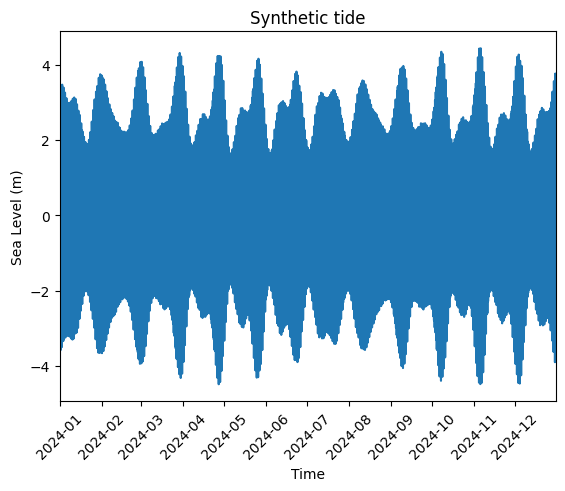

In [ ]:
### We have a tidal signal!
plt.plot(times, tide)
plt.xlim(times[0], times[-1])
plt.title('Synthetic tide')
plt.xlabel('Time')
plt.ylabel('Sea Level (m)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Simple Application of RTide

RTide can be run using three lines of code. By default, RTide takes pandas dataframes with date-time indexes as input and measurements provided in a column labeled 'observations'.

In addition to the observations dataframe, RTide also requires the latitude, longitude, and the sampling rate (mult_val) of the observations given in samples per hour. Note the open-source implementation of RTide will not require the specification of a sampling rate.

To remove the need to recompute the global tide function in between runs, a path can be specified to save the computed input functions

In [ ]:
df = pd.DataFrame({'observations': tide}, index = times)

#### Model Overview ####
Train days is: 0
Learning Rate is: 1e-05
Loss is: MAE
Linear Epochs: 0
Standard Epochs: 500
Regularization: 0.0
Epoch 1/500
131/131 - 3s - loss: 0.9534 - val_loss: 0.8127 - lr: 1.0000e-05 - 3s/epoch - 24ms/step
Epoch 2/500
131/131 - 1s - loss: 0.7404 - val_loss: 0.6113 - lr: 1.0000e-05 - 598ms/epoch - 5ms/step
Epoch 3/500
131/131 - 1s - loss: 0.5671 - val_loss: 0.4560 - lr: 1.0000e-05 - 547ms/epoch - 4ms/step
Epoch 4/500
131/131 - 1s - loss: 0.4407 - val_loss: 0.3884 - lr: 1.0000e-05 - 525ms/epoch - 4ms/step
Epoch 5/500
131/131 - 0s - loss: 0.3772 - val_loss: 0.3556 - lr: 1.0000e-05 - 310ms/epoch - 2ms/step
Epoch 6/500
131/131 - 0s - loss: 0.3452 - val_loss: 0.3283 - lr: 1.0000e-05 - 338ms/epoch - 3ms/step
Epoch 7/500
131/131 - 0s - loss: 0.3233 - val_loss: 0.3076 - lr: 1.0000e-05 - 306ms/epoch - 2ms/step
Epoch 8/500
131/131 - 0s - loss: 0.3047 - val_loss: 0.2895 - lr: 1.0000e-05 - 316ms/epoch - 2ms/step
Epoch 9/500
131/131 - 0s - loss: 0.2880 - val_loss: 0.270

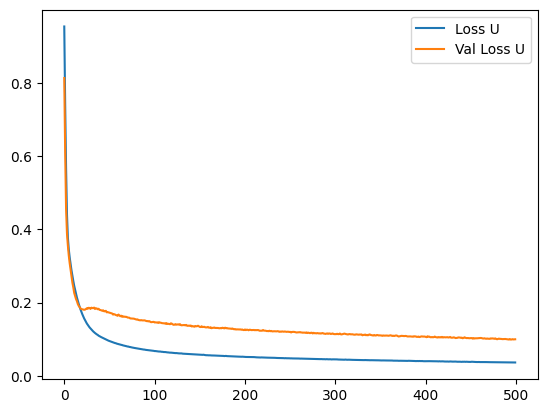

274/274 [==============================] - 0s 2ms/step


In [ ]:
model = RTide(df, lat = 44.9062, lon = -66.996201, mult_val = 1, path = './posnorad') ## mult_val == measurements per hour ## standard is other...

model.Prepare_Dfs(radiational = False, pos = True) ## Including radiational input functions and positive time lags in the analysis
model.run_NN(loss = 'MAE', regularization_strength = 0.0)

### Let's now run some stats compared to UTide:

Unsurprisingly, when dealing with a purely harmonic signal HA is going to be hard to beat...
This exposes a crucial distinction between these methods. Because RTide is not composed of harmonics it can only get $\epsilon$ close to a truly harmonic function. However, this same characteristic enables RTide to use less data and more efficiently be applied to non-stationary data. Equivalent harmonic predictions are also simultaneously computed and included in the results.


In [ ]:
results = model.model_predictions
print('Train Results (RTide)')
_ = calc_stats(results['train_preds'], results['train_labels'], verbose = True)
print('Train Results (UTide)')
_ = calc_stats(results['utide_train_preds'], results['train_labels'], verbose = True)

print('Test Results (RTide)')
_ = calc_stats(results['test_preds'], results['test_labels'], verbose = True)
print('Test Results (UTide)')
_ = calc_stats(results['utide_test_preds'], results['test_labels'], verbose = True)

print('Test Results (RTide-Tide)')

### RTide will automatically compute the equivalent harmonic tide for it's learned prediction. When dealing with pure tidal signals this is generally preferrable.
_ = calc_stats(results['RTide_Tide'], results['test_labels'], verbose = True)

Train Results (RTide)
r2: 0.9966168074897805 MSE: 0.013321603875201427 MAE : 0.08414954562707604 MAPE : 0.187944098889618
Train Results (UTide)
r2: 0.9997741715104873 MSE: 0.0008926102826289075 MAE : 0.025023200468403218 MAPE : 0.7786098228466352
Test Results (RTide)
r2: 0.9966168074897805 MSE: 0.013321603875201427 MAE : 0.08414954562707604 MAPE : 0.187944098889618
Test Results (UTide)
r2: 0.9997741715104873 MSE: 0.0008926102826289075 MAE : 0.025023200468403218 MAPE : 0.7786098228466352
Test Results (RTide-Tide)
r2: 0.9994314421863434 MSE: 0.0022332606116256533 MAE : 0.03828714896998096 MAPE : 0.2634190327160438


### Non-tidal Forcing

Far more interesting than a pure tidal signal is one contaminated by non-tidal forcing. Here, we show how RTide can be employed to efficiently study these effects and generate predictions. In particular we look at a signal contaminated by an external surge, and want to predict both the true tidal signal and the nonlinear tide-surge response. A simple approximation for this behavior is given by:


$\zeta(t) = \zeta_T + \zeta_S + A\times\zeta_S(\zeta_T ' + \zeta_T '')$

#### Create Surge Signal

In [ ]:
## Tide
times = pd.date_range(start = '2024-01-01 00:00:00+00:00', periods=24*365*10, freq="6T",tz='UTC')
time_vals = times.to_julian_date().to_numpy()

### Computing the contribution of each constituent
individual_tides = []
for i,j in enumerate(constit_freqs):
    individual_tides.append(amplitudes[i]*np.cos(24*j*np.array(time_vals) * 2 * np.pi + (phases[i] *np.pi /180)))

tide = np.sum(individual_tides, axis = 0)
## Surges
surge_min = 0.1
surge_max = 1
surge_duration_min = 0.25
surge_duration_max = 4

np.random.seed(45) ### Using same seed for consistency
surge_duration = [np.random.uniform(surge_duration_min,surge_duration_max) for i in range(26)]
np.random.seed(46) ### Using same seed for consistency
surge_intensity= [np.random.uniform(surge_min,surge_max) for i in range(26)]

surges = [surge_intensity[i]*(1 - np.cos(24*2*np.pi*np.arange(0,surge_duration[i]*10, 0.041666666666666664)/(surge_duration[i]*24*10))) for i in range(len(surge_duration))]

### Tide-Surge Function
first_derivative = np.gradient(tide)
second_derivative = np.gradient(np.gradient(tide))
indices = np.where((first_derivative > 0) & (second_derivative > 0))[0]
mults = np.zeros(len(tide))
mults[indices] = 1
window_size = 4
smooth_mults = 3*(first_derivative+ second_derivative)
smooth_mults_test = np.zeros(len(tide))

random_indices = random_indices_within_chunks(tide, 14*24*10, 96*10)

mod_tide = tide.copy()
for i,surge in enumerate(surges):
  for xval in range(len(surge)):
    mod_tide[xval+random_indices[i]] += surge[xval]
    smooth_mults_test[xval+random_indices[i]] = smooth_mults[xval + random_indices[i]] * surge[xval]

observations = mod_tide + smooth_mults_test ## Tide + Surge + tide-surge
surge = mod_tide - tide

surge_df = pd.DataFrame({'observations': observations, 'surge': surge}, index = times)

#### Plotting

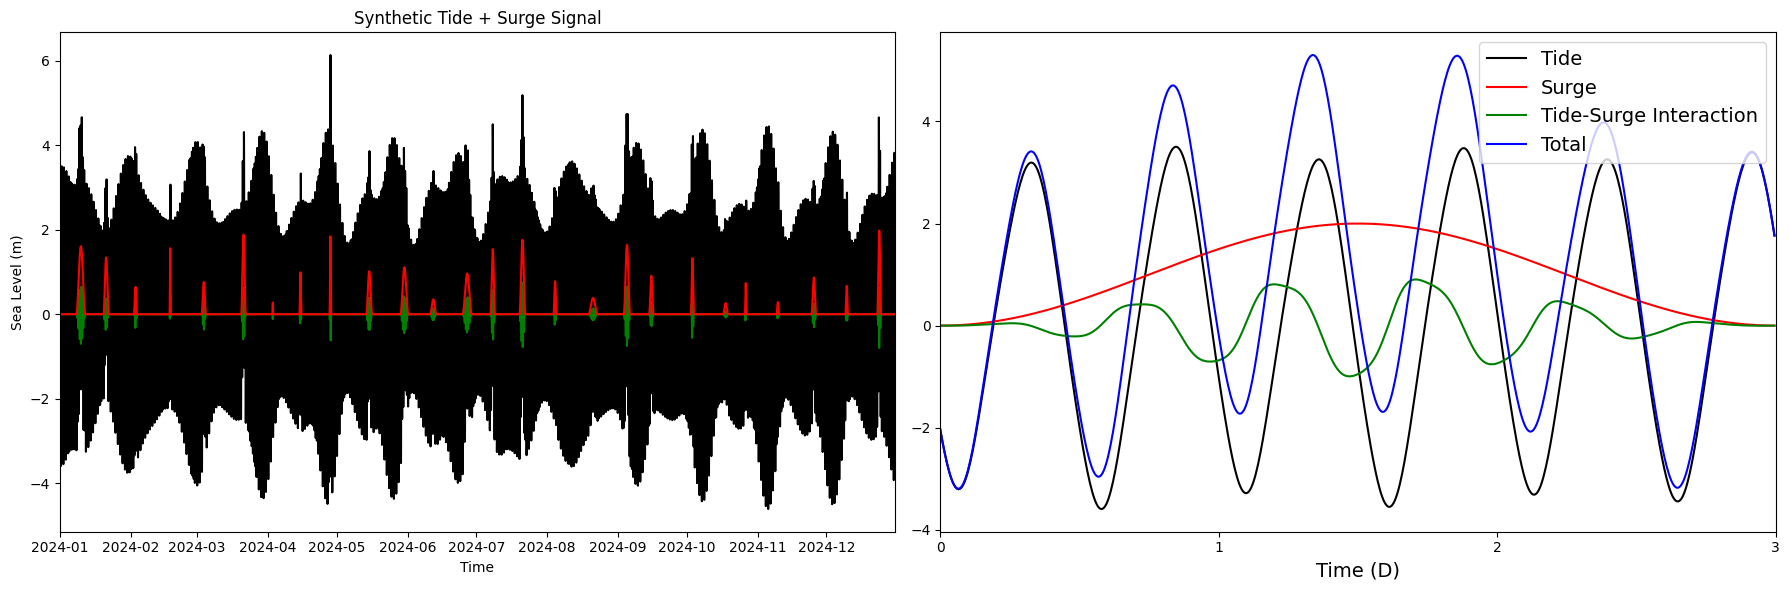

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df, df2, and tide are defined somewhere in your code
# First subplot
fig = plt.figure(figsize=(18, 6))  # Adjust the width and height as needed

plt.subplot(1, 2, 1)

plt.plot(surge_df.index, surge_df.observations, label = 'observations', color = 'black')
plt.plot(surge_df.index, smooth_mults_test, label = 'tide-surge', color = 'green')
plt.plot(surge_df.index, surge_df.surge, label = 'surge', color = 'red')
plt.ylabel('Sea Level (m)')
plt.xlabel('Time')
plt.xlim(surge_df.index[0], surge_df.index[-1])
plt.title("Synthetic Tide + Surge Signal")

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(tide[:72 * 10], label='Tide', color='k')
surge2 = (1 - np.cos(24 * 2 * np.pi * np.arange(0, 3 * 10, 0.041666666666666664) / (72 * 10)))
plt.plot(surge2, label='Surge', color='red')
surge3 = (1 - np.cos(24 * 2 * np.pi * np.arange(0, 365, 0.041666666666666664) / (72 * 10)))
window_size = 7
smooth_mults2 = np.convolve(mults, np.ones(window_size) / window_size, mode='same')
# Adjust the range of smoothed values to be between 0 and 1
smooth_vals = smooth_mults2 + 0.1
first_derivative1 = np.gradient(tide)
second_derivative1 = np.gradient(np.gradient(tide))
plt.plot(surge3[:72 * 10] * 3 * (first_derivative1 + second_derivative1)[:72 * 10],
         label='Tide-Surge Interaction', color='green')
total = tide[:72 * 10] + surge3[:72 * 10] + surge3[:72 * 10] * 3 * (first_derivative1 + second_derivative1)[:72 * 10]
plt.plot(total, label='Total', color='blue')
plt.xlim(0, 72 * 10)
plt.xticks([0,240, 480, 720], [0, 1, 2, 3])
plt.xlabel('Time (D)', fontsize = 14)

plt.legend(fontsize = 14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Running Response
Multivariate inputs are simply included as an additional column in the input dataframe. It still only takes three lines of code to build and train a model for any number of multivariate inputs!

#### Model Overview ####
Train days is: 0
Learning Rate is: 1e-05
Linear Epochs: 100
Standard Epochs: 250
Regularization: 0.01
Epoch 1/100
595/595 - 4s - loss: 2.9629 - val_loss: 2.5958 - lr: 1.0000e-05 - 4s/epoch - 7ms/step
Epoch 2/100
595/595 - 2s - loss: 2.2676 - val_loss: 2.1298 - lr: 1.0000e-05 - 2s/epoch - 3ms/step
Epoch 3/100
595/595 - 3s - loss: 1.9748 - val_loss: 1.9066 - lr: 1.0000e-05 - 3s/epoch - 5ms/step
Epoch 4/100
595/595 - 3s - loss: 1.7813 - val_loss: 1.7254 - lr: 1.0000e-05 - 3s/epoch - 4ms/step
Epoch 5/100
595/595 - 2s - loss: 1.6077 - val_loss: 1.5762 - lr: 1.0000e-05 - 2s/epoch - 4ms/step
Epoch 6/100
595/595 - 2s - loss: 1.4530 - val_loss: 1.4608 - lr: 1.0000e-05 - 2s/epoch - 3ms/step
Epoch 7/100
595/595 - 2s - loss: 1.3218 - val_loss: 1.3820 - lr: 1.0000e-05 - 2s/epoch - 3ms/step
Epoch 8/100
595/595 - 2s - loss: 1.2134 - val_loss: 1.3097 - lr: 1.0000e-05 - 2s/epoch - 3ms/step
Epoch 9/100
595/595 - 3s - loss: 1.1216 - val_loss: 1.2423 - lr: 1.0000e-05 - 3s/epoch - 

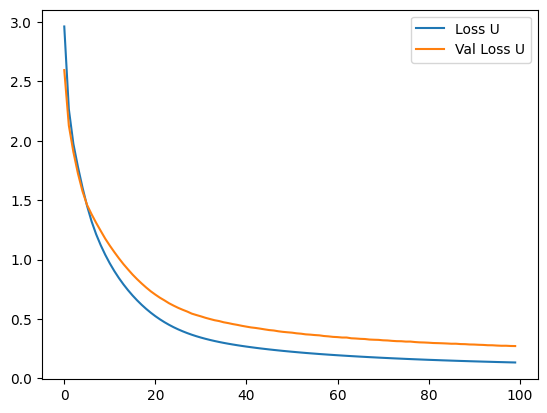

Epoch 1/250
1256/1256 [==============================] - 5s 3ms/step - loss: 0.1512 - val_loss: 0.2755 - lr: 1.0000e-05
Epoch 2/250
1256/1256 [==============================] - 4s 3ms/step - loss: 0.1485 - val_loss: 0.2722 - lr: 1.0000e-05
Epoch 3/250
1256/1256 [==============================] - 5s 4ms/step - loss: 0.1464 - val_loss: 0.2691 - lr: 1.0000e-05
Epoch 4/250
1256/1256 [==============================] - 4s 3ms/step - loss: 0.1447 - val_loss: 0.2664 - lr: 1.0000e-05
Epoch 5/250
1256/1256 [==============================] - 4s 3ms/step - loss: 0.1428 - val_loss: 0.2647 - lr: 1.0000e-05
Epoch 6/250
1256/1256 [==============================] - 5s 4ms/step - loss: 0.1411 - val_loss: 0.2638 - lr: 1.0000e-05
Epoch 7/250
1256/1256 [==============================] - 4s 3ms/step - loss: 0.1395 - val_loss: 0.2578 - lr: 1.0000e-05
Epoch 8/250
1256/1256 [==============================] - 4s 3ms/step - loss: 0.1380 - val_loss: 0.2582 - lr: 1.0000e-05
Epoch 9/250
1256/1256 [=================

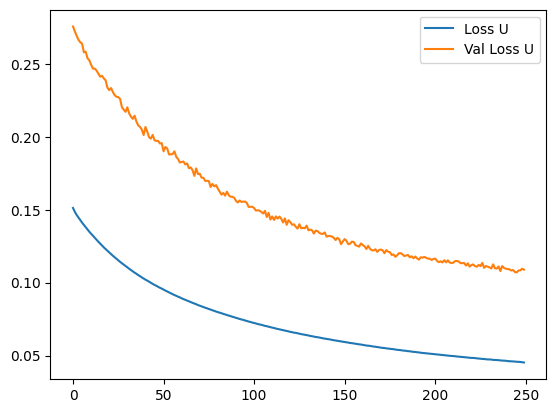

2644/2644 [==============================] - 4s 2ms/step


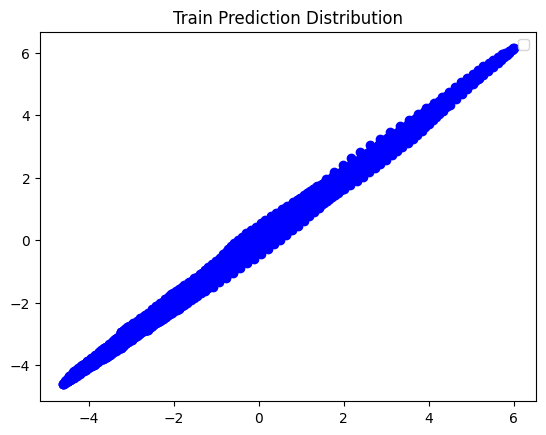

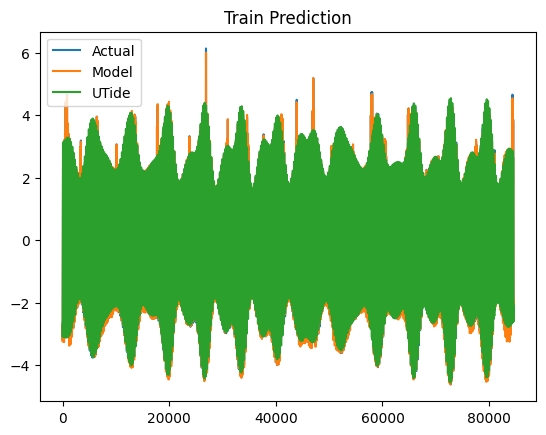

In [ ]:
model = RTide(surge_df, lat = 44.9062, lon = -66.996201, mult_val = 10, path = './surges2') ## mult_val == measurements per hour

model.Prepare_Dfs(radiational = False, pos = True) ## Including radiational input functions and positive time lags in the analysis

model.train_test_predict(train_epochs1 = 100, train_epochs2 = 250, regularization_strength = 0.01, verbose = True)

In [ ]:
### These are results for the reg 0.01*** NEW
results = model.model_predictions
print('Train Results (RTide)')
_ = calc_stats(results['train_preds'], results['train_labels'], verbose = True)
print('Train Results (UTide)')
_ = calc_stats(results['utide_train_preds'], results['train_labels'], verbose = True)

print('Test Results (RTide)')
_ = calc_stats(results['test_preds'], results['test_labels'], verbose = True)
print('Test Results (UTide)')
_ = calc_stats(results['utide_test_preds'], results['test_labels'], verbose = True)

Train Results (RTide)
r2: 0.9991493456777859 MSE: 0.0034034069382759143 MAE : 0.038222435208357636 MAPE : 0.15116387207818993
Train Results (UTide)
r2: 0.9799692171102635 MSE: 0.07850978939165561 MAE : 0.13933682143112833 MAPE : 0.7633902606920443
Test Results (RTide)
r2: 0.9991493456777859 MSE: 0.0034034069382759143 MAE : 0.038222435208357636 MAPE : 0.15116387207818993
Test Results (UTide)
r2: 0.9799692171102635 MSE: 0.07850978939165561 MAE : 0.13933682143112833 MAPE : 0.7633902606920443


Text(0.5, 1.0, 'First Surge Event')

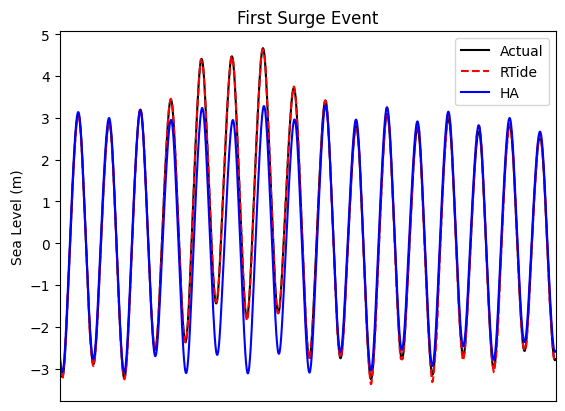

In [ ]:
### Great! It seems RTide has succesfully predicted the first surge event!
plt.plot(results['train_labels'][0:2000], color = 'black', label = 'Actual')
plt.plot(results['train_preds'][0:2000], color = 'red', linestyle = '--', label = 'RTide')
plt.plot(results['utide_train_preds'][0:2000], color = 'blue', label = 'HA')
plt.legend()
plt.xlim(0,2000)
plt.xticks([])
plt.ylabel('Sea Level (m)')
plt.title('First Surge Event')

### Tidal Comparisons:
The comparison above is, of course, unfair as the HA looks to predict the true tidal signal and NOT the total water level. Hence, let's first evaluate the quality of the derived tidal signals. The RTide tidal signal is computed by first passing in zeros for the external forcing. This yields the RTide learned oceanic response under exclusively tidal forcing. For simplicity, harmonic analysis is then run on the RTide predicted tidal signal to yield a signal of pure harmonics.

In [ ]:
#### New Tide Res
print('Tide Results (RTide)')
_ = calc_stats(results['RTide_Tide'], tide[1500:-1500], verbose = True)
print('Tide Results (UTide)')
_ = calc_stats(results['utide_train_preds'], tide[1500:-1500], verbose = True)

Tide Results (RTide)
r2: 0.9999473406598315 MSE: 0.00020617252512003187 MAE : 0.01135256071570782 MAPE : 0.033869587327505994
Tide Results (UTide)
r2: 0.9971421372048841 MSE: 0.011201269934874391 MAE : 0.08713342908844193 MAPE : 0.5213152683829924


Text(0.5, 1.0, 'Tidal Residuals')

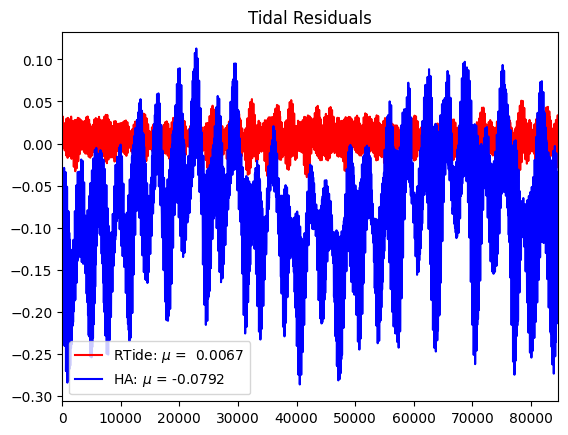

In [ ]:
### New Tide Res
plt.plot(tide[1500:-1500] - results['RTide_Tide'], label = f'RTide: $\mu$ =  {round(np.average(tide[1500:-1500] - results["RTide_Tide"]),4)}', color = 'red')
plt.plot(tide[1500:-1500] -results['utide_train_preds'], label = f'HA: $\mu$ = {round(np.average(tide[1500:-1500] - results["utide_train_preds"]),4)}', color = 'blue')
plt.xlim(0,len(results['RTide_Tide']))
plt.legend()
plt.savefig('tidal_residuals.png', dpi = 300)
plt.title('Tidal Residuals')

We can see that the surge contamination results in errors in both the RTide and HA derived tidal signals. The biasing, however, is significantly less for RTide. Let's have a look at the derived tidal constituents to see what the difference is. After building the model, RTide will automatically compute the associated harmonic predictions for both standard HA and the RTide tidal prediction. These are stored in UTide bunch objects and can be used the exact same way.

In [ ]:
#### Helper Function for Computing
def constit_RMS(model_amplitudes, model_phases, HA_amplitudes, HA_phases,  actual_amplitudes, actual_phases, stat_type = 'Amplitudes'):
  tvals = np.linspace(0,2*np.pi,1000)
  HA_errs = 0
  RT_errs = 0
  for i,const in enumerate(constits):
    print(f"Computing {stat_type} errors")
    if stat_type == 'RMS:'
      RTide_errors = np.sqrt(((model_amplitudes[i]*np.cos(tvals + (model_phases[i]*np.pi/180)) - actual_amplitudes[i]*np.cos(tvals + (actual_phases[i]*np.pi/180))))**2)
      HA_errors = np.sqrt(((HA_amplitudes[i]*np.cos(tvals + (HA_phases[i]*np.pi/180)) - actual_amplitudes[i]*np.cos(tvals + (actual_phases[i]*np.pi/180))))**2)
    elif stat_type == 'Amplitude':
      RTide_errors = abs(model_amplitudes[i] - actual_amplitudes[i])
      HA_errors = abs(HA_amplitudes[i] - actual_amplitudes[i])
    else:
      RTide_errors = abs(model_phases[i] - actual_phases[i])
      HA_errors = abs(HA_phases[i] - actual_phases[i])

    RT_errs += np.average(RTide_errors)
    HA_errs += np.average(HA_errors)
    print(f'{const}: RTide {round(np.average(RTide_errors),4)}')
    print(f'{const}: HA    {round(np.average(HA_errors),4)}')
  print(f"Total RT Error:", RT_errs)
  print(f"Total UT Error:", HA_errs)

In [ ]:
### Obtaining constituents from RTide
RTide_amplitudes = model.RTide_HA['A']
RTide_phases = model.RTide_HA['g']

HA_amplitudes = model.UTide_HA['A']
HA_phases = model.UTide_HA['g']

### Printing results
constit_RMS(RTide_amplitudes, RTide_phases, HA_amplitudes, HA_phases, amplitudes, phases)